Importación de librerías y configuración inicial

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from PIL import Image
import time

# Configuración de semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuración de matplotlib para español
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Librerías importadas correctamente")


✅ Librerías importadas correctamente


Visualización de imágenes de muestra

📊 Metadatos cargados para mostrar etiquetas


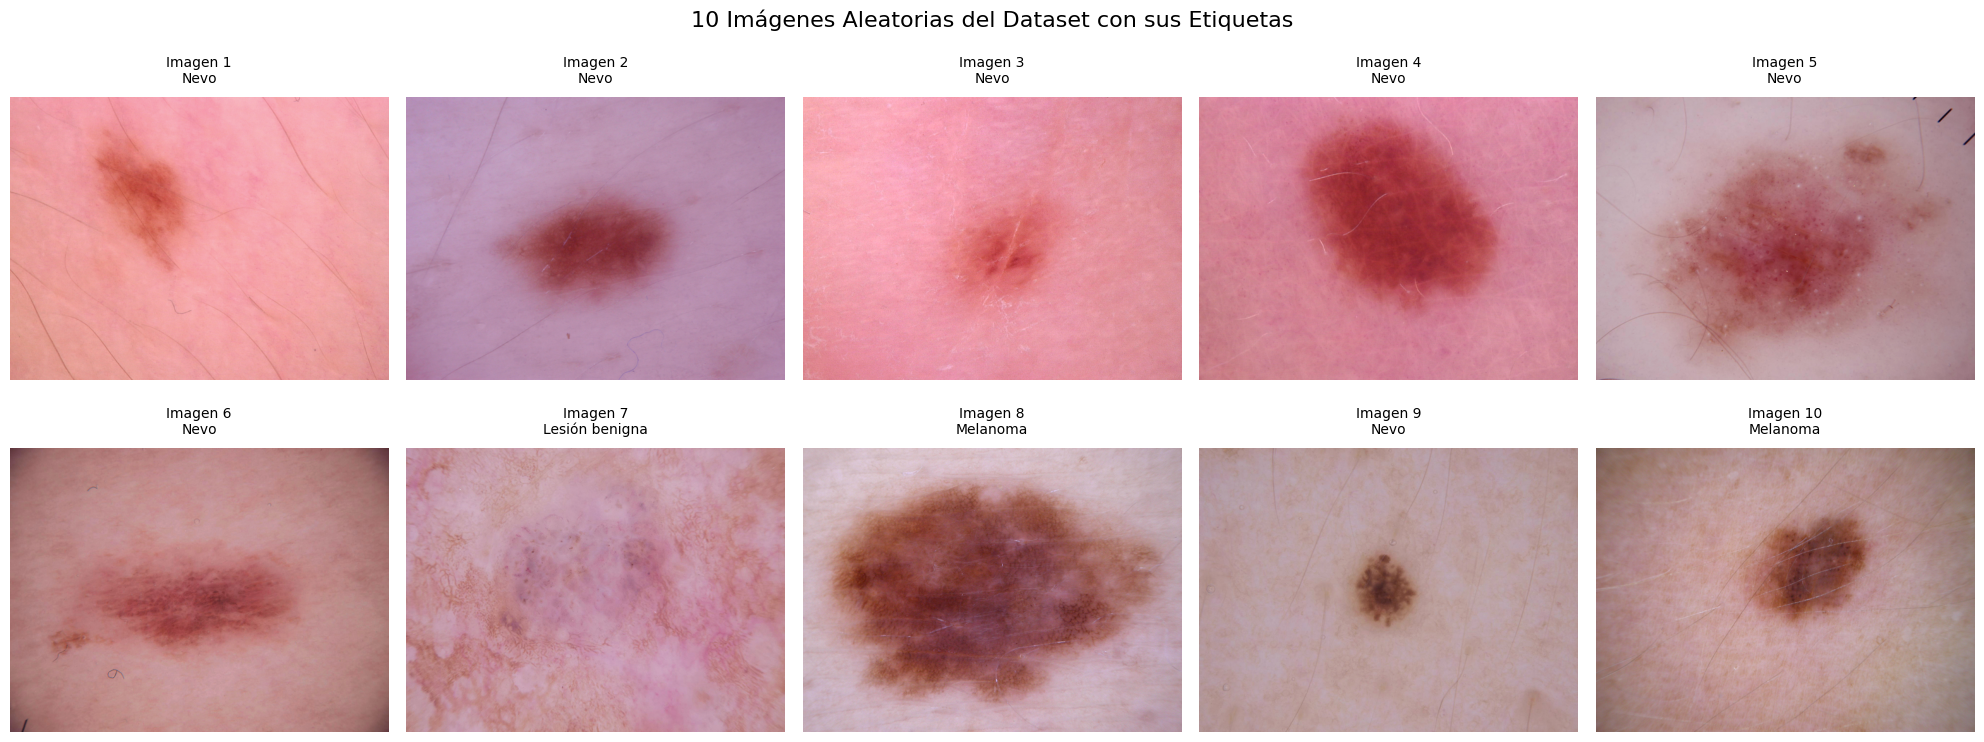

In [2]:
def mostrar_imagenes_muestra_con_etiquetas():
    """Muestra imágenes de muestra con sus etiquetas correspondientes"""
    folder1 = './skin-cancer-mnist-ham10000/HAM10000_images_part_1'
    folder2 = './skin-cancer-mnist-ham10000/HAM10000_images_part_2'

    # Verificar si las carpetas existen
    if not os.path.exists(folder1) or not os.path.exists(folder2):
        print("⚠️ No se encontraron las carpetas de imágenes. Asegúrate de que el dataset esté en la ruta correcta.")
        return

    # Cargar metadatos si están disponibles
    try:
        metadatos = pd.read_csv('./skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
        print("📊 Metadatos cargados para mostrar etiquetas")
    except FileNotFoundError:
        print("⚠️ No se pudieron cargar los metadatos. Solo se mostrarán las imágenes.")
        metadatos = None

    images1 = [os.path.join(folder1, f) for f in os.listdir(folder1) if f.endswith('.jpg')]
    images2 = [os.path.join(folder2, f) for f in os.listdir(folder2) if f.endswith('.jpg')]
    
    all_images = images1 + images2
    random_images = random.sample(all_images, min(10, len(all_images)))

    def display_images_with_labels(images, title):
        plt.figure(figsize=(20, 8))
        for i, img_path in enumerate(images):
            img = Image.open(img_path)
            plt.subplot(2, 5, i + 1)
            plt.imshow(img)
            plt.axis('off')
            
            # Extraer nombre del archivo sin extensión
            img_name = os.path.basename(img_path).replace('.jpg', '')
            
            # Buscar la etiqueta en los metadatos si están disponibles
            if metadatos is not None:
                try:
                    etiqueta_row = metadatos[metadatos['image_id'] == img_name]
                    if not etiqueta_row.empty:
                        dx_label = etiqueta_row['dx'].iloc[0]
                        # Mapeo de etiquetas originales a nombres en español
                        label_map = {
                            'akiec': 'Queratosis actínica',
                            'bcc': 'Carcinoma basocelular', 
                            'bkl': 'Lesión benigna',
                            'df': 'Dermatofibroma',
                            'mel': 'Melanoma',
                            'nv': 'Nevo',
                            'vasc': 'Carcinoma espinocelular'
                        }
                        nombre_clase = label_map.get(dx_label, dx_label)
                        plt.title(f"Imagen {i + 1}\n{nombre_clase}", fontsize=10, pad=10)
                    else:
                        plt.title(f"Imagen {i + 1}\nEtiqueta no encontrada", fontsize=10, pad=10)
                except Exception as e:
                    plt.title(f"Imagen {i + 1}\nError: {str(e)[:20]}", fontsize=10, pad=10)
            else:
                plt.title(f"Imagen {i + 1}\nSin metadatos", fontsize=10, pad=10)
                
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()

    display_images_with_labels(random_images, "10 Imágenes Aleatorias del Dataset con sus Etiquetas")

# Ejecutar la función de visualización mejorada
mostrar_imagenes_muestra_con_etiquetas()

Carga y exploración de datos

In [3]:
# Cargar metadatos
try:
    metadatos = pd.read_csv('./skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
    print("📊 Metadatos cargados correctamente")
    print(f"Forma de los metadatos: {metadatos.shape}")
    print("\n🔍 Primeras 5 filas de metadatos:")
    print(metadatos.head())
    
    print("\n📈 Distribución de clases:")
    print(metadatos['dx'].value_counts())
    
except FileNotFoundError:
    print("⚠️ No se pudo cargar el archivo de metadatos")

# Cargar datos de imágenes procesadas
try:
    datos = pd.read_csv('./skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
    print(f"\n📊 Datos de imágenes cargados correctamente")
    print(f"Forma de los datos: {datos.shape}")
    
    # Separar características y etiquetas
    X = datos.drop('label', axis=1)
    y = datos['label']
    
    print(f"Forma de X: {X.shape}")
    print(f"Forma de y: {y.shape}")
    print(f"Clases únicas: {np.unique(y)}")
    
except FileNotFoundError:
    print("⚠️ No se pudo cargar el archivo de datos de imágenes")

📊 Metadatos cargados correctamente
Forma de los metadatos: (10015, 7)

🔍 Primeras 5 filas de metadatos:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

📈 Distribución de clases:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

📊 Datos de imágenes cargados correctamente
Forma de los datos: (10015, 2353)
Forma de X: (10015, 2352)
Forma de y: (10015,)
Clases únicas: [0 1 2 3 4 5 6]


Definición de etiquetas y mapeo de clases

In [4]:
# Mapeo de números a nombres de condiciones de piel
ETIQUETAS_CANCER = {
    0: 'Queratosis actínica',      # akiec - Actinic keratoses
    1: 'Carcinoma basocelular',    # bcc - Basal cell carcinoma
    2: 'Lesión benigna',           # bkl - Benign keratosis-like lesions
    3: 'Dermatofibroma',           # df - Dermatofibroma
    4: 'Melanoma',                 # mel - Melanoma
    5: 'Nevo',                     # nv - Melanocytic nevi
    6: 'Carcinoma espinocelular'   # vasc - Vascular lesions
}

def obtener_nombre_clase(numero_clase):
    """Convierte el número de clase a nombre legible"""
    return ETIQUETAS_CANCER.get(numero_clase, f"Clase desconocida ({numero_clase})")

print("🏷️ Mapeo de clases definido:")
for clase, nombre in ETIQUETAS_CANCER.items():
    print(f"  {clase}: {nombre}")


🏷️ Mapeo de clases definido:
  0: Queratosis actínica
  1: Carcinoma basocelular
  2: Lesión benigna
  3: Dermatofibroma
  4: Melanoma
  5: Nevo
  6: Carcinoma espinocelular


Preprocesamiento y balanceado de datos

In [5]:
def balancear_datos(x, y, random_state=SEED):
    """Balancea los datos usando oversampling mejorado"""
    print("⚖️ Iniciando balanceado de datos...")
    
    # Convertir a numpy arrays
    if hasattr(x, 'values'):
        x_array = x.values
    else:
        x_array = np.array(x)
    
    if hasattr(y, 'values'):
        y_array = y.values
    else:
        y_array = np.array(y)
    
    clases_unicas, conteos = np.unique(y_array, return_counts=True)
    max_conteo = max(conteos)
    
    print(f"Distribución original de clases:")
    for clase, conteo in zip(clases_unicas, conteos):
        print(f"  {obtener_nombre_clase(clase)}: {conteo} muestras")
    
    x_balanceado = []
    y_balanceado = []
    
    for clase_label in clases_unicas:
        indices_clase = np.where(y_array == clase_label)[0]
        clase_x = x_array[indices_clase]
        clase_y = y_array[indices_clase]
        
        # Oversample para igualar a la clase mayoritaria
        if len(clase_x) < max_conteo:
            clase_x_remuestreada, clase_y_remuestreada = resample(
                clase_x, clase_y, 
                n_samples=max_conteo, 
                random_state=random_state
            )
        else:
            clase_x_remuestreada, clase_y_remuestreada = clase_x, clase_y
            
        x_balanceado.append(clase_x_remuestreada)
        y_balanceado.append(clase_y_remuestreada)
    
    x_final = np.vstack(x_balanceado)
    y_final = np.hstack(y_balanceado)
    
    print(f"\n✅ Datos balanceados - Nueva forma: {x_final.shape}")
    return x_final, y_final

# Aplicar balanceado de datos
X_balanceado, y_balanceado = balancear_datos(X, y)
X_balanceado = X_balanceado.reshape(-1, 28, 28, 3).astype(np.float32)

# Normalización mejorada
print("🔧 Aplicando normalización...")
X_balanceado = X_balanceado / 255.0  # Normalización simple pero efectiva
print(f"Rango de datos después de normalización: [{X_balanceado.min():.3f}, {X_balanceado.max():.3f}]")


⚖️ Iniciando balanceado de datos...
Distribución original de clases:
  Queratosis actínica: 327 muestras
  Carcinoma basocelular: 514 muestras
  Lesión benigna: 1099 muestras
  Dermatofibroma: 115 muestras
  Melanoma: 6705 muestras
  Nevo: 142 muestras
  Carcinoma espinocelular: 1113 muestras

✅ Datos balanceados - Nueva forma: (46935, 2352)
🔧 Aplicando normalización...
Rango de datos después de normalización: [0.000, 1.000]


Aumento de datos (Data Augmentation)

In [6]:
def aumentar_datos(imagenes, etiquetas, porcentaje=0.2):
    """Aplica data augmentation usando TensorFlow"""
    print(f"🔄 Aplicando aumento de datos ({porcentaje*100}% de las muestras)...")
    
    num_muestras_aumentadas = int(porcentaje * len(imagenes))
    rng = np.random.default_rng(SEED)
    indices = rng.choice(len(imagenes), num_muestras_aumentadas, replace=False)
    
    imagenes_seleccionadas = imagenes[indices]
    etiquetas_seleccionadas = etiquetas[indices]
    
    imagenes_aumentadas = []
    
    for img in imagenes_seleccionadas:
        img = tf.expand_dims(img, 0)
        
        # Aplicar transformaciones aleatorias
        if tf.random.uniform([]) > 0.5:
            img = tf.image.flip_left_right(img)
        
        if tf.random.uniform([]) > 0.5:
            img = tf.image.flip_up_down(img)
        
        if tf.random.uniform([]) > 0.7:
            img = tf.image.rot90(img, k=tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32))
        
        # Ajustes de brillo, contraste y saturación más suaves
        img = tf.image.random_brightness(img, max_delta=0.15)
        img = tf.image.random_contrast(img, lower=0.85, upper=1.15)
        img = tf.image.random_saturation(img, lower=0.85, upper=1.15)
        
        # Ruido gaussiano ligero
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.02)
        img = img + noise
        
        # Recorte y redimensionado aleatorio
        img = tf.image.random_crop(img, size=[1, 26, 26, 3])
        img = tf.image.resize(img, [28, 28])
        img = tf.clip_by_value(img, 0.0, 1.0)
        
        imagenes_aumentadas.append(tf.squeeze(img, 0))
    
    imagenes_aumentadas = tf.stack(imagenes_aumentadas)
    
    # Combinar datos originales con aumentados
    X_combinado = np.concatenate((imagenes, imagenes_aumentadas.numpy()), axis=0)
    y_combinado = np.concatenate((etiquetas, etiquetas_seleccionadas), axis=0)
    
    print(f"✅ Aumento de datos completado. Nueva forma: {X_combinado.shape}")
    return X_combinado, y_combinado

# Aplicar aumento de datos
X_aumentado, y_aumentado = aumentar_datos(X_balanceado, y_balanceado)


🔄 Aplicando aumento de datos (20.0% de las muestras)...
✅ Aumento de datos completado. Nueva forma: (56322, 28, 28, 3)


División de datos

In [7]:
# División en entrenamiento, validación y prueba
X_temp, X_test, y_temp, y_test = train_test_split(
    X_aumentado, y_aumentado, test_size=0.15, random_state=SEED, stratify=y_aumentado
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.18, random_state=SEED, stratify=y_temp
)

print("📊 División de datos completada:")
print(f"  Entrenamiento: {X_train.shape[0]} muestras")
print(f"  Validación: {X_val.shape[0]} muestras") 
print(f"  Prueba: {X_test.shape[0]} muestras")

# Verificar distribución de clases
print("\n📈 Distribución de clases en conjunto de entrenamiento:")
clases_unicas, conteos = np.unique(y_train, return_counts=True)
for clase, conteo in zip(clases_unicas, conteos):
    print(f"  {obtener_nombre_clase(clase)}: {conteo} muestras")

📊 División de datos completada:
  Entrenamiento: 39255 muestras
  Validación: 8618 muestras
  Prueba: 8449 muestras

📈 Distribución de clases en conjunto de entrenamiento:
  Queratosis actínica: 5616 muestras
  Carcinoma basocelular: 5636 muestras
  Lesión benigna: 5588 muestras
  Dermatofibroma: 5622 muestras
  Melanoma: 5603 muestras
  Nevo: 5591 muestras
  Carcinoma espinocelular: 5599 muestras


Definición del modelo optimizado LeNet-5+

In [8]:
def crear_modelo_optimizado():
    """Crea un modelo LeNet-5 mejorado con técnicas de regularización"""
    modelo = Sequential([
        # Primera capa convolucional con más filtros
        Conv2D(filters=32, kernel_size=(5, 5), activation='relu', 
               input_shape=(28, 28, 3), padding='same'),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2, 2)),
        
        # Segunda capa convolucional
        Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2, 2)),
        
        # Tercera capa convolucional adicional para mayor capacidad
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        
        # Aplanamiento
        Flatten(),
        
        # Capas densas con dropout
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(128, activation='relu'),
        Dropout(0.3),
        
        # Capa de salida
        Dense(7, activation='softmax')
    ])
    
    return modelo

# Crear y compilar el modelo
modelo = crear_modelo_optimizado()

# Compilar con optimizador Adam y learning rate adaptativo
modelo.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    metrics=['accuracy']
)

# Mostrar resumen del modelo
print("🧠 Arquitectura del modelo:")
modelo.summary()


c:\Users\yorka\OneDrive\Escritorio\2025_1\ia\Red CNN\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🧠 Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 7, 7, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,768,135 (6.74 MB)

 Trainable params: 1,767,687 (6.74 MB)

 Non-trainable params: 448 (1.75 KB)

Configuración de callbacks avanzados

In [9]:
# Callbacks para mejorar el entrenamiento
callbacks = [
    # Reducir learning rate cuando no mejore la validación
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Parada temprana para evitar sobreentrenamiento
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Guardar el mejor modelo
    ModelCheckpoint(
        filepath='mejor_modelo_cancer_piel.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("⚙️ Callbacks configurados:")
print("  - Reducción automática de learning rate")
print("  - Parada temprana")
print("  - Guardado del mejor modelo")


⚙️ Callbacks configurados:
  - Reducción automática de learning rate
  - Parada temprana
  - Guardado del mejor modelo


Entrenamiento del modelo

In [10]:
print("🚀 Iniciando entrenamiento del modelo...")
tiempo_inicio = time.time()

# Entrenar el modelo
historial = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,  # Batch size más pequeño para mejor convergencia
    epochs=50,      # Más épocas con early stopping
    callbacks=callbacks,
    verbose=1
)

tiempo_entrenamiento = time.time() - tiempo_inicio
print(f"\n⏰ Tiempo total de entrenamiento: {tiempo_entrenamiento:.2f} segundos")


🚀 Iniciando entrenamiento del modelo...
Epoch 1/50
613/614 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3139 - loss: 1.8356
Epoch 1: val_accuracy improved from None to 0.20005, saving model to mejor_modelo_cancer_piel.keras
614/614 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.3550 - loss: 1.6443 - val_accuracy: 0.2000 - val_loss: 7.9817 - learning_rate: 0.0010
Epoch 2/50
613/614 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4491 - loss: 1.3673
Epoch 2: val_accuracy improved from 0.20005 to 0.49988, saving model to mejor_modelo_cancer_piel.keras
614/614 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.4807 - loss: 1.2976 - val_accuracy: 0.4999 - val_loss: 1.2821 - learning_rate: 0.0010
Epoch 3/50
613/614 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5711 - loss: 1.0848
Epoch 3: val_accuracy did not improve from 0.49988
614/614 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.6024 - loss: 1.0243 - val_accuracy: 0.4487 - val_loss: 1.4838 - learning_rate: 0.0010
Epoch 4/50
612/6

Evaluación del modelo


In [12]:
print("📊 Evaluando rendimiento del modelo...")

# Evaluación en conjuntos de entrenamiento, validación y prueba
puntuacion_train = modelo.evaluate(X_train, y_train, verbose=0)
puntuacion_val = modelo.evaluate(X_val, y_val, verbose=0)
puntuacion_test = modelo.evaluate(X_test, y_test, verbose=0)

print("🎯 Resultados de evaluación:")
print(f"  Entrenamiento - Pérdida: {puntuacion_train[0]:.4f}, Precisión: {puntuacion_train[1]:.4f}")
print(f"  Validación - Pérdida: {puntuacion_val[0]:.4f}, Precisión: {puntuacion_val[1]:.4f}")
print(f"  Prueba - Pérdida: {puntuacion_test[0]:.4f}, Precisión: {puntuacion_test[1]:.4f}")


📊 Evaluando rendimiento del modelo...
🎯 Resultados de evaluación:
  Entrenamiento - Pérdida: 0.0023, Precisión: 0.9995
  Validación - Pérdida: 0.5173, Precisión: 0.9434
  Prueba - Pérdida: 0.5373, Precisión: 0.9364


Visualización de métricas de entrenamiento

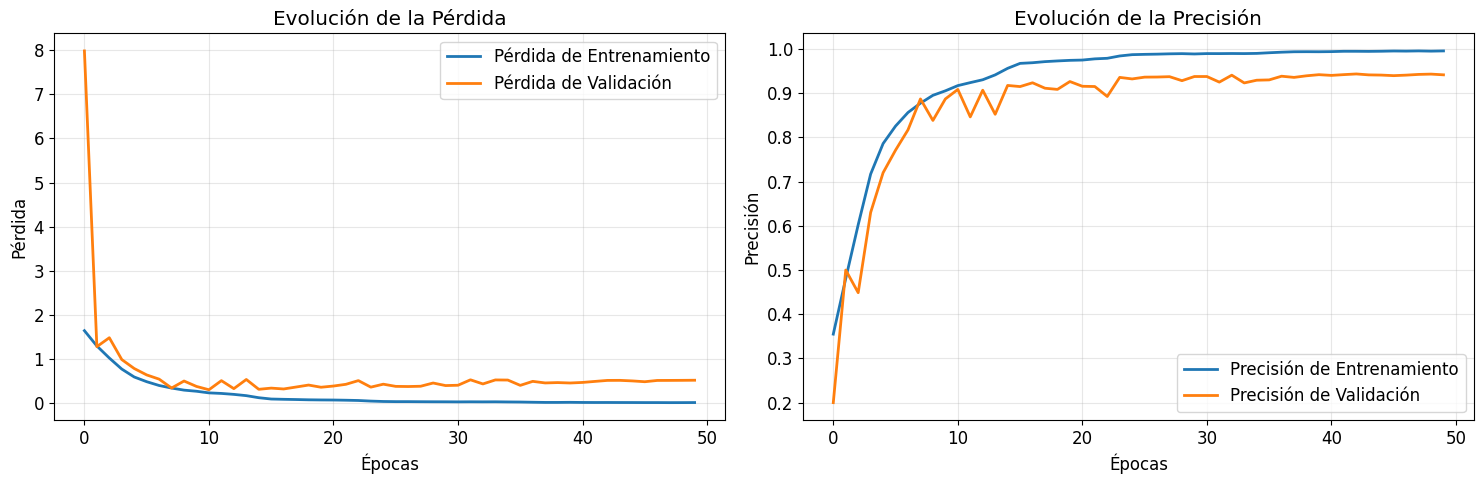

In [13]:
def graficar_metricas_entrenamiento(historial):
    """Grafica las métricas de pérdida y precisión durante el entrenamiento"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfica de pérdida
    ax1.plot(historial.history['loss'], label='Pérdida de Entrenamiento', linewidth=2)
    ax1.plot(historial.history['val_loss'], label='Pérdida de Validación', linewidth=2)
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida')
    ax1.set_title('Evolución de la Pérdida')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfica de precisión
    ax2.plot(historial.history['accuracy'], label='Precisión de Entrenamiento', linewidth=2)
    ax2.plot(historial.history['val_accuracy'], label='Precisión de Validación', linewidth=2)
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Precisión')
    ax2.set_title('Evolución de la Precisión')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Graficar métricas
graficar_metricas_entrenamiento(historial)

13: Análisis detallado con matriz de confusión

🔍 Realizando análisis detallado de rendimiento...
📈 Métricas generales:
  Precisión: 0.9371
  Recall: 0.9364
  Exactitud: 0.9364


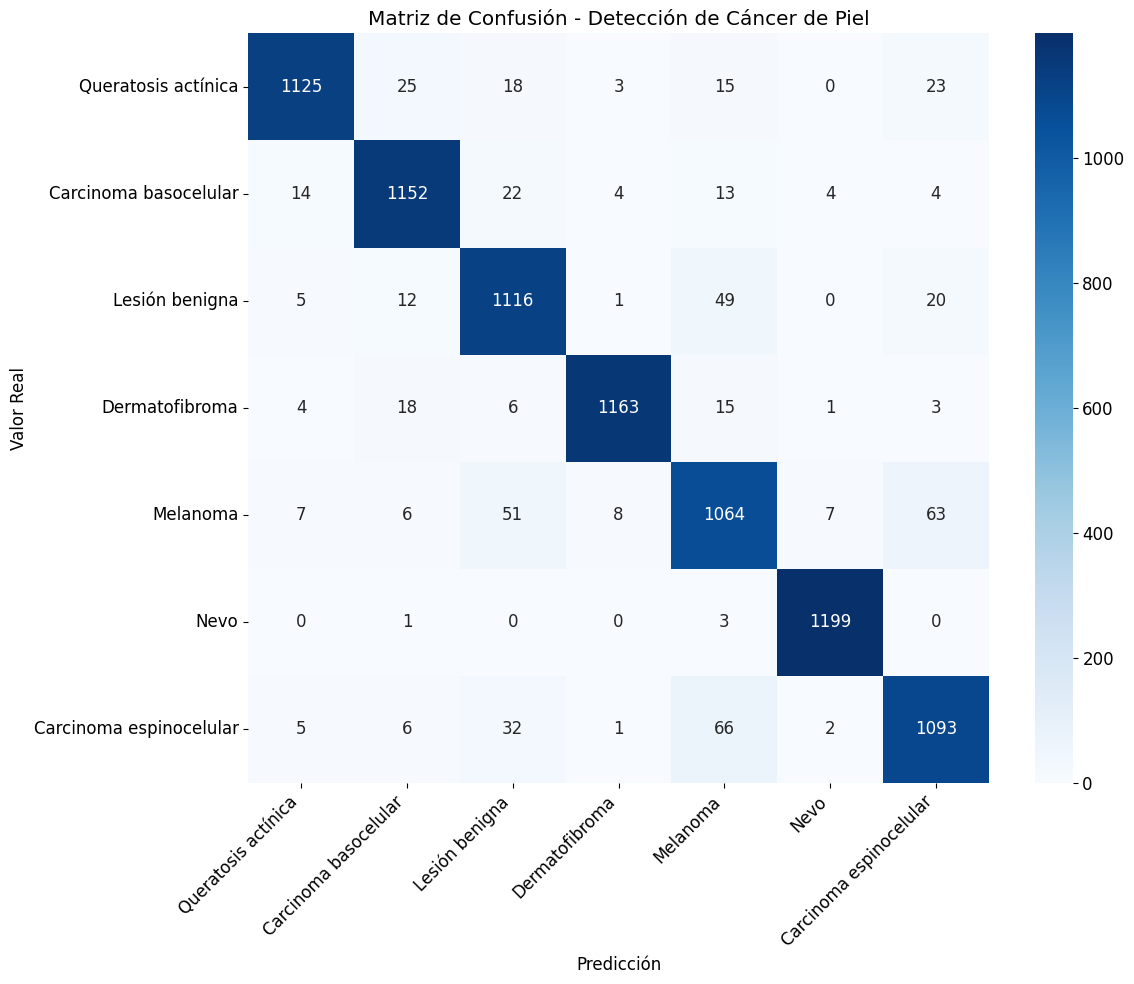


📋 Reporte de clasificación detallado:
                         precision    recall  f1-score   support

    Queratosis actínica     0.9698    0.9305    0.9498      1209
  Carcinoma basocelular     0.9443    0.9497    0.9470      1213
         Lesión benigna     0.8964    0.9277    0.9118      1203
         Dermatofibroma     0.9856    0.9612    0.9732      1210
               Melanoma     0.8686    0.8823    0.8754      1206
                   Nevo     0.9885    0.9967    0.9925      1203
Carcinoma espinocelular     0.9063    0.9071    0.9067      1205

               accuracy                         0.9364      8449
              macro avg     0.9371    0.9364    0.9366      8449
           weighted avg     0.9371    0.9364    0.9366      8449



In [14]:
def analizar_rendimiento_detallado(modelo, X_test, y_test):
    """Realiza un análisis detallado del rendimiento del modelo"""
    print("🔍 Realizando análisis detallado de rendimiento...")
    
    # Predicciones
    y_pred_proba = modelo.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Métricas generales
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"📈 Métricas generales:")
    print(f"  Precisión: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Exactitud: {accuracy:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Graficar matriz de confusión
    plt.figure(figsize=(12, 10))
    etiquetas = [obtener_nombre_clase(i) for i in range(7)]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=etiquetas, yticklabels=etiquetas)
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión - Detección de Cáncer de Piel')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Reporte de clasificación detallado
    print("\n📋 Reporte de clasificación detallado:")
    reporte = classification_report(y_test, y_pred, 
                                    target_names=etiquetas, 
                                    digits=4)
    print(reporte)
    
    return y_pred_proba, y_pred

# Realizar análisis detallado
probabilidades_prediccion, predicciones = analizar_rendimiento_detallado(modelo, X_test, y_test)


Función de Predicción Individual

In [ ]:
def predecir_imagen_externa(ruta_imagen, modelo):
    try:
        # Verificar que el archivo existe
        if not os.path.exists(ruta_imagen):
            print(f"❌ No se encontró la imagen en la ruta: {ruta_imagen}")
            return None
        
        # Cargar imagen
        img = Image.open(ruta_imagen)
        
        # Convertir a RGB si es necesario
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Redimensionar a 28x28 (tamaño que espera el modelo)
        img_resized = img.resize((28, 28))
        
        # Convertir a array numpy y normalizar
        img_array = np.array(img_resized).astype(np.float32)
        img_array = img_array / 255.0  # Normalización
        
        # Agregar dimensión de batch
        img_array = np.expand_dims(img_array, axis=0)
        
        # Realizar predicción
        predicciones = modelo.predict(img_array, verbose=0)
        clase_predicha = np.argmax(predicciones[0])
        confianza = np.max(predicciones[0])
        nombre_clase = obtener_nombre_clase(clase_predicha)
        
        # Mostrar imágenes
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Imagen original
        ax1.imshow(img)
        ax1.set_title(f'Imagen Original\nArchivo: {os.path.basename(ruta_imagen)}', fontsize=12)
        ax1.axis('off')
        
        # Imagen procesada
        ax2.imshow(img_resized)
        ax2.set_title('Imagen Procesada (28x28)', fontsize=12)
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar resultado
        print("🔍 RESULTADO DE LA PREDICCIÓN")
        print("=" * 50)
        print(f"📋 Diagnóstico: {nombre_clase}")
        print(f"🎯 Confianza: {confianza:.1%}")
        
        # Gráfico de probabilidades
        plt.figure(figsize=(10, 6))
        
        # Preparar datos para el gráfico
        clases = [obtener_nombre_clase(i) for i in range(7)]
        probabilidades = predicciones[0] * 100
        colores = ['red' if i == clase_predicha else 'lightblue' for i in range(7)]
        
        # Crear gráfico de barras horizontal
        barras = plt.barh(clases, probabilidades, color=colores)
        
        # Personalizar gráfico
        plt.xlabel('Probabilidad (%)')
        plt.title(f'Distribución de Probabilidades\nDiagnóstico: {nombre_clase} ({confianza:.1%})', fontsize=14)
        plt.grid(axis='x', alpha=0.3)
        
        # Agregar valores en las barras
        for i, (barra, prob) in enumerate(zip(barras, probabilidades)):
            plt.text(prob + 1, barra.get_y() + barra.get_height()/2, 
                    f'{prob:.1f}%', va='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        return None  # No retornar valores técnicos
        
    except Exception as e:
        print(f"❌ Error al procesar la imagen: {str(e)}")
        return None, None, None


In [5]:
#predecir modelo 
predecir_imagen_externa('1.jpg', modelo)   #link de al imagen https://www.mayoclinic.org/es/diseases-conditions/melanoma/in-depth/melanoma/art-20546856

NameError: name 'modelo' is not defined

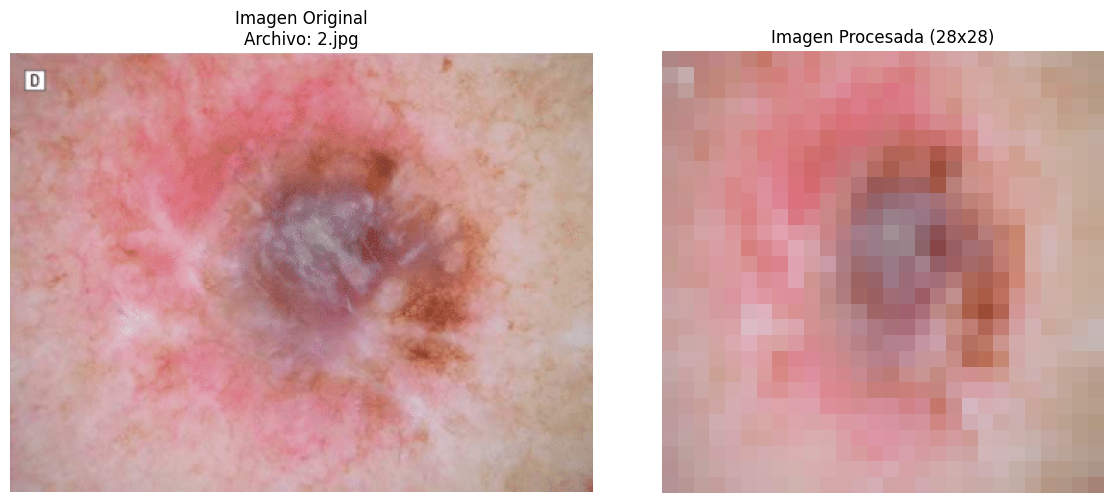

🔍 RESULTADO DE LA PREDICCIÓN
📋 Diagnóstico: Dermatofibroma
🎯 Confianza: 56.8%


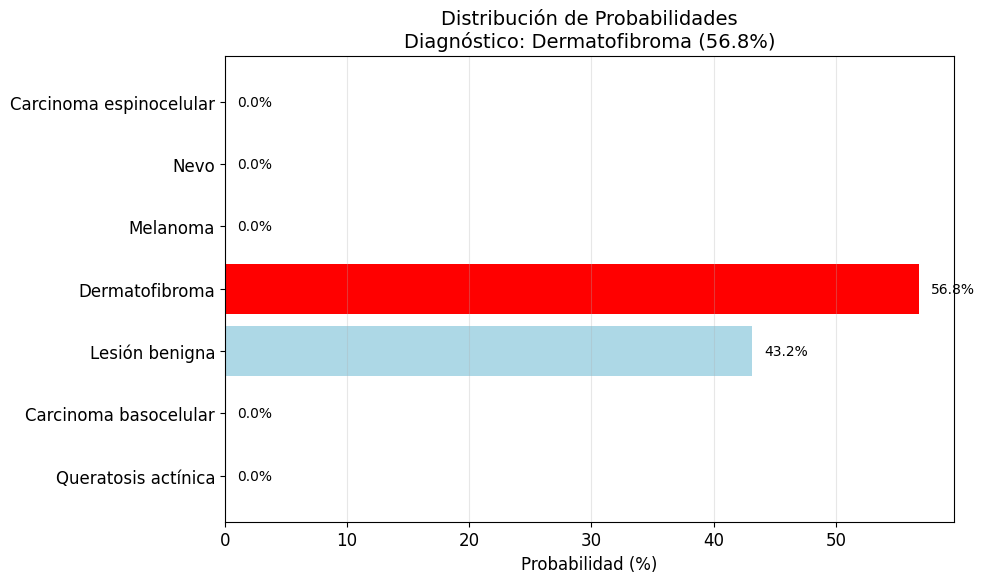

(np.int64(3),
 array([1.9118507e-09, 7.0614855e-12, 4.3156567e-01, 5.6822067e-01,
        2.1369051e-04, 7.3900734e-09, 2.2488449e-11], dtype=float32),
 'Dermatofibroma')

In [ ]:
#predecir modelo 
predecir_imagen_externa('2.jpg', modelo)   #link de al imagen https://www.researchgate.net/figure/Patterns-of-dermatofibroma-A-Peripheral-homogeneous-pigmentation-and-central-white_fig5_5642887

🔍 RESULTADO DE LA PREDICCIÓN
📋 Diagnóstico: Queratosis actínica
🎯 Confianza: 100.0%


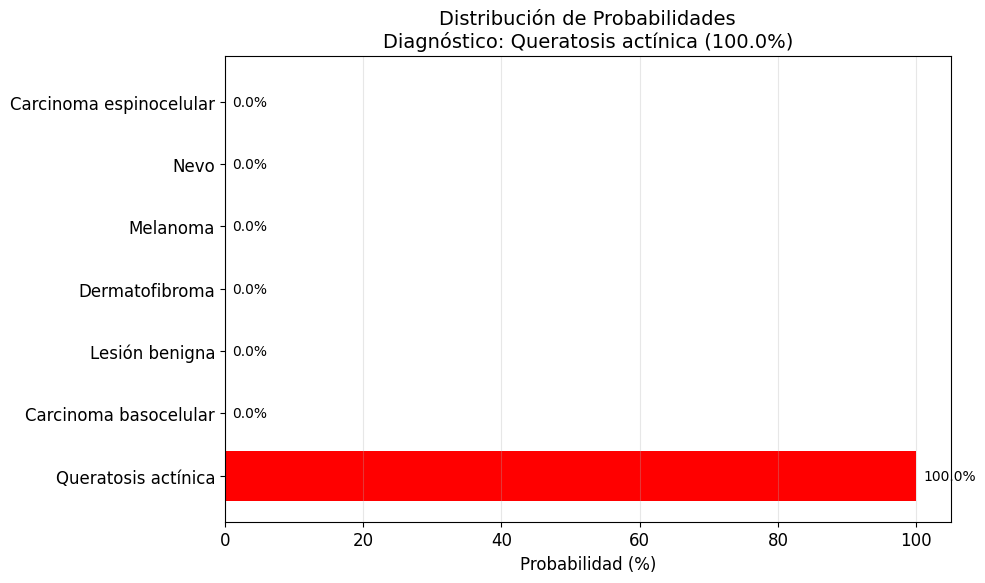

(np.int64(0),
 array([9.9990118e-01, 6.9864732e-11, 1.0465003e-09, 3.4386837e-11,
        1.2196946e-07, 3.9811384e-18, 9.8692282e-05], dtype=float32),
 'Queratosis actínica')

In [ ]:
#predecir modelo 
predecir_imagen_externa('3.jpg', modelo)   #link de al imagen https://clinicamerced.cl/dermatologia/queratosis-actinica/

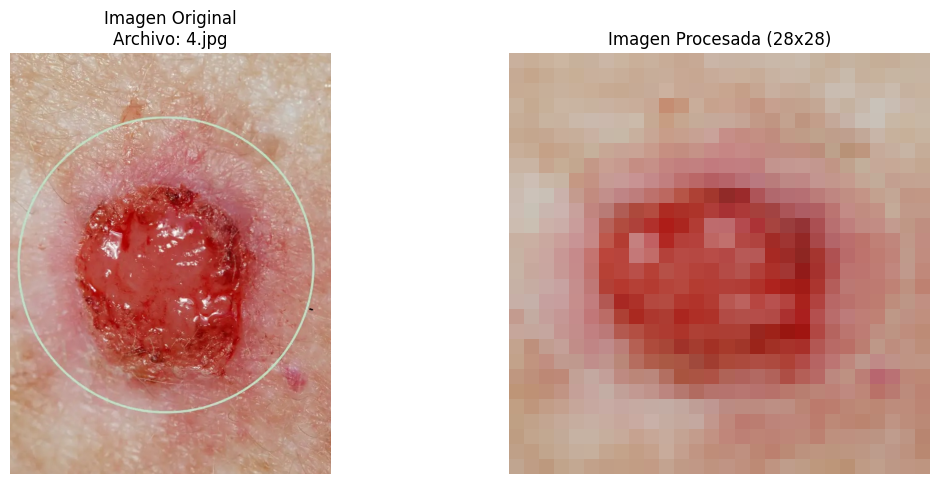

🔍 RESULTADO DE LA PREDICCIÓN
📋 Diagnóstico: Carcinoma basocelular
🎯 Confianza: 92.4%


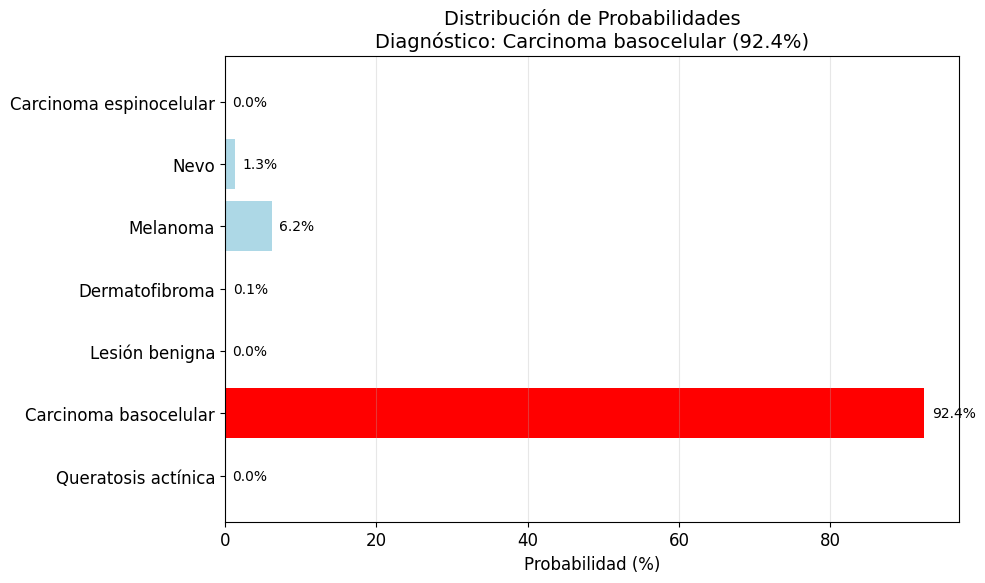

(np.int64(1),
 array([2.2739521e-10, 9.2379701e-01, 1.3877848e-06, 5.3798663e-04,
        6.2356535e-02, 1.3301768e-02, 5.3079029e-06], dtype=float32),
 'Carcinoma basocelular')

In [ ]:
#predecir modelo 
predecir_imagen_externa('4.jpg', modelo)   #link de al imagen https://www.dermaniac.com/blog/carcinoma-basocelular-el-tipo-de-cancer-de-piel-mas-comun

🔍 RESULTADO DE LA PREDICCIÓN
📋 Diagnóstico: Carcinoma espinocelular
🎯 Confianza: 82.2%


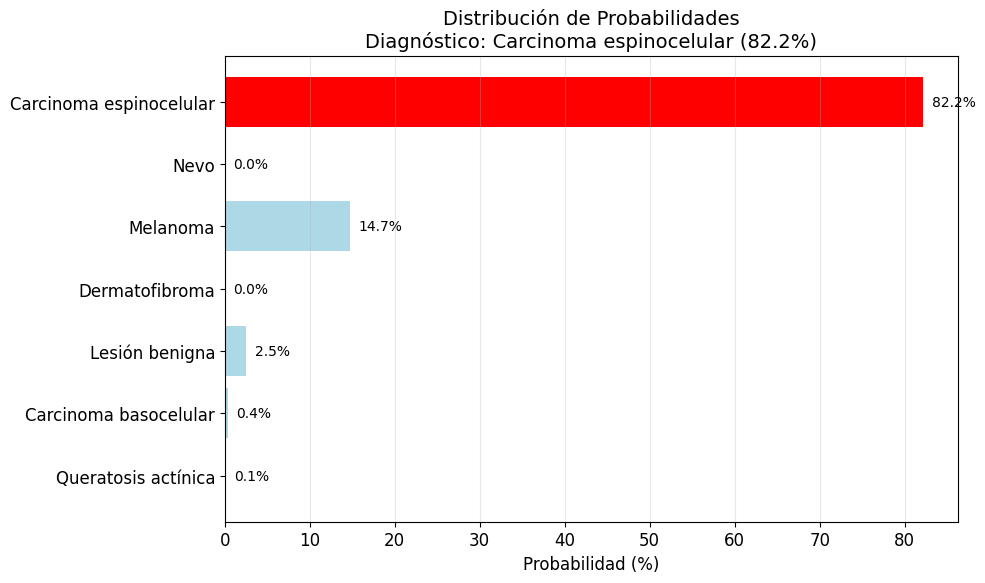

(np.int64(6),
 array([1.1188772e-03, 3.9874157e-03, 2.5037359e-02, 4.6682768e-04,
        1.4739729e-01, 3.7652353e-04, 8.2161564e-01], dtype=float32),
 'Carcinoma espinocelular')

In [ ]:
#predecir modelo 
predecir_imagen_externa('5.jpg', modelo)   #link de al imagen https://www.sciencedirect.com/science/article/pii/S1134207223000610